# Train Model
The following notebook contains the code for training the Zero-Shot model which is based on a sequence-to-sequence architecture with attention mechanism.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import sys
import random
import pickle
import os
from datetime import datetime
import matplotlib.pyplot as plt
import json
from scipy.sparse import load_npz

#root path to src folder; adjust to own rooth path 
sys.path.append("C:/Users/User/foodcap")

#misc
import src.config as config
from src.data.data_loading import get_loader
from src.data.load_build_vocab import Vocabulary
from src.model.encoder import EncoderRNN
from src.model.decoder import Decoder
from src.model.Seq2Seq import Seq2Seq
from src.model.trainer import train
from src.model.topic_embedding import TFIDF
from src.utils import save_list_to_file, save_model

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### The following parameters can be set during training: 
* **recipe1M**: boolean variable which specifies which vocabulary and embeddings to use. *True* for using the enlarged vocabulary and embeddings of the recipe1M dataset <br/>
* **resNet**:boolean varibale which specifies which features to use. *True* for using the ResNet features <br/>
* **moe**:boolean varibale which specifies whether the model should be trained with the Mixture of Experts (MoE) layer.<br />
* **num_experts**: specifies the number of experts for the MoE layer<br />
* **num_epochs**:specifies the number of epochs for training the model<br/>
* **print_every**:specifies the frequency of printing the training and validaiton results and saving the model <br/>
* **learning_rate**:specifies the learning rate for the Adam optimizer<br/>
* **batch_size**:specifies the batch size for each iteration<br/>
* **teaching_forcing_ratio**: During training, the teacher forcing ratio can be between 0 and 1. At inference time it has to be set to 0
* **limit**: specifies the length of the generated output sequence. If set to zero the length equals to the maximum length of the annotations in the training dataset
* **num_train**:specifies the number of samples in training <br/>
* **num_val**:specifies the number of samples in validation 


In [2]:
# changeable parameters
recipe1M_embeddings = True
resNet = True
moe = True
num_experts = 8

num_epochs = 20#250
print_every = 2 #20
learning_rate = 0.001
batch_size = 256 
teaching_forcing_ratio = 0.8
limit = 0
limit_validation = 25

# number of all training samples: 11711 
# test: 1102 
# val: 1016
num_train = 2
num_val = 2

### Model Specifications

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
num_workers = 0

data_dir = config.DATA["data_dir"]
if resNet: 
    feature_dir = data_dir + "resnet_features/"
else: 
    feature_dir = data_dir + "bn_features/"

tfidf_weight_matrix_path_original = data_dir + 'tfidf_weight_matrix.npz'
tfidf_weight_matrix_path_processed = data_dir + 'tfidf_weight_matrix_correct.npy'
recipe_label_index_path = data_dir + 'label_index_foodtype.csv'

save_model_path = os.path.join(
    "../models/",
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(save_model_path)

if recipe1M_embeddings:
    vocab_path = '../data/vocab_recipe1M.pkl'
else:
    vocab_path = "../data/vocab.pkl"
    
# Model parameters
if resNet:
    in_features = 512
else:
    in_features = 1024

hidden_size_encoder = 300
num_layers_encoder = 1
bidirectional_encoder = True
num_dnn_layers_encoder = 1
dropout_encoder = 0.1
encoder_output_size = 300

embedding_size = 300
hidden_size_decoder = 300
num_layers_decoder = 1
bidirectional_decoder = True
dropout_decoder = 0.1

num_dir_enc = 2 if bidirectional_encoder else 1
num_dir_dec = 2 if bidirectional_decoder else 1

decoder_input_size = hidden_size_encoder *num_dir_enc+ embedding_size
linear_input_size =  decoder_input_size + hidden_size_decoder*2

### Data Loading
Load vocabulary and index lookup data 

In [4]:
print("Load vocabulary")
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
        
vocab_size= len(vocab)
print("Vocab size", vocab_size)

print("Load Data")
yc2_all = pd.read_csv("../data/data_all.csv")

train_idx = yc2_all[yc2_all.subset_new == "training"].index
val_idx = yc2_all[yc2_all.subset_new == "validation"].index

train_idx = random.sample(list(train_idx), num_train)
val_idx = random.sample(list(val_idx), num_val)

yc2_train = yc2_all.iloc[train_idx]
yc2_val = yc2_all.iloc[val_idx]

yc2_train = yc2_train.reset_index().drop('level_0', axis=1)
yc2_val = yc2_val.reset_index().drop('level_0', axis=1)

yc2_train_small = yc2_train[['video_seg_id', 'recipe_label', 'sentence', 'recipe_index']]
yc2_val_small = yc2_val[['video_seg_id', 'recipe_label', 'sentence', 'recipe_index']]

del yc2_all
del yc2_train
del yc2_val

print("Done!")

Load vocabulary
Vocab size 30462
Load Data
Done!


### Build Seq2Seq Model 

In [5]:
encoder = EncoderRNN(num_features=in_features, hidden_size=hidden_size_encoder, num_layers=num_layers_encoder,
                     num_dnn_layers=num_dnn_layers_encoder, dropout=dropout_encoder,
                     bidirectional=bidirectional_encoder, device=device).to(device)

decoder = Decoder(decoder_hid_dem=hidden_size_decoder, encoder_hid_dem=hidden_size_encoder, vocab=vocab,
                  vocab_size=vocab_size, recipe1M_embeddings=recipe1M_embeddings, embedding_dim=embedding_size,
                  decoder_input_size=decoder_input_size, linear_input_size=linear_input_size,
                  bidirectional_encoder=bidirectional_encoder, bidirectional_decoder=bidirectional_decoder,
                  dropout=dropout_decoder, moe=moe, num_experts=num_experts, device=device).to(device)

model = Seq2Seq(encoder, decoder, device).to(device)

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [6]:
# if the model should be trained with the MoE layer, then the TFIDF based topic embeddings 
# for the different recipe types are added to the decoder
if moe:
    with open(data_dir + 'R1M_vocab.json', 'rb') as f:
        R1M_vocab_names = json.load(f)
        
    tfidf_weight_matrix = load_npz(tfidf_weight_matrix_path_original)
    recipe_labels = pd.read_csv(recipe_label_index_path)
    
    tfidf = TFIDF(decoder, vocab, recipe_labels, R1M_vocab_names, device)
    topic_embedding = tfidf.get_w_tfidf_via_names(tfidf_weight_matrix)
    decoder.add_topic_embedding(topic_embedding, non_trainable=True)
    
    if use_cuda: 
        np.save(tfidf_weight_matrix_path_processed,topic_embedding.to('cpu').data.numpy())
    else: 
        np.save(tfidf_weight_matrix_path_processed,topic_embedding.data.numpy())

    # once the tfidf_weight_matrix_correct is created and saved to the data directory, the above code does not have to be 
    # executed again. It is then sufficient to execute the following line of code
    # decoder.add_topic_embedding(torch.tensor(np.load(tfidf_weight_matrix_path_processed),).float(), non_trainable=True)

### Build data loader for the training and validation dataset 

In [7]:
data_loader_train = get_loader(feature_dir, yc2_train_small, vocab, decoder, batch_size=batch_size, shuffle=True,
                               num_workers=num_workers, data_dir=data_dir, resnet=resNet, device=device)
data_loader_val = get_loader(feature_dir, yc2_val_small, vocab, decoder, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, data_dir=data_dir, resnet=resNet, device=device)

### Loss and optimizer


In [8]:
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

PAD_IDX = vocab.word2idx['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

### Training
During training the training loss is as well as the evalution scores for training and evaluation are saved.<br />
Furthermore, if the model achieves a better value for one of the evaluation scores on the validations set, the model is saved.<br />
Also, after a defined number of epochs (set with print_every) the model is saved and the values for the training loss and METEOR scores on the training and vaidation set are reported

In [9]:
losses_train = []
bleus_1_train = []
bleus_2_train = []
bleus_3_train = []
bleus_4_train = []
meteors_train = []

bleus_1_val = []
bleus_2_val = []
bleus_3_val = []
bleus_4_val = []
meteors_val = []

meteor_best = 0
meteor_train_best = 0
b1_best = 0
b2_best = 0
b3_best = 0
b4_best = 0

print("Start training")
for epoch in range(num_epochs):
    e_loss_train, bleu_1_train, bleu_2_train, bleu_3_train, bleu_4_train, meteor_score_train, seq_probs_train,\
    captions_train = train(model=model, data_loader=data_loader_train, vocab=vocab, optimizer=optimizer,
                           criterion=criterion, teaching_forcing_ratio=teaching_forcing_ratio, limit=limit,
                           train=True)
    
    
    losses_train.append(e_loss_train)
    bleus_1_train.append(bleu_1_train)
    bleus_2_train.append(bleu_2_train)
    bleus_3_train.append(bleu_3_train)
    bleus_4_train.append(bleu_4_train)
    meteors_train.append(meteor_score_train)

    # save training loss and evaluation scores of training 
    save_list_to_file(losses_train, save_model_path, 'loss_train_list.json')
    save_list_to_file(meteors_train, save_model_path, 'meteor_train_list.json')
    save_list_to_file(bleus_1_train, save_model_path, 'bleus1_train_list.json')
    save_list_to_file(bleus_2_train, save_model_path, 'bleus2_train_list.json')
    save_list_to_file(bleus_3_train, save_model_path, 'bleus3_train_list.json')
    save_list_to_file(bleus_4_train, save_model_path, 'bleus4_train_list.json')
    
    if use_cuda: 
        torch.cuda.empty_cache()

    e_loss_val, bleu_1_val, bleu_2_val, bleu_3_val, bleu_4_val, meteor_score_val, seq_probs_val, captions_val = train(
        model=model, data_loader=data_loader_val, vocab=vocab, optimizer=optimizer,
        criterion=criterion, teaching_forcing_ratio=0, limit=limit_validation,train=False)
    
    bleus_1_val.append(bleu_1_val)
    bleus_2_val.append(bleu_2_val)
    bleus_3_val.append(bleu_3_val)
    bleus_4_val.append(bleu_4_val)
    meteors_val.append(meteor_score_val)
    
    # save evaluation scores of the validation
    save_list_to_file(meteors_val, save_model_path, 'meteor_val_list.json')
    save_list_to_file(bleus_1_val, save_model_path, 'bleus1_val_list.json')
    save_list_to_file(bleus_2_val, save_model_path, 'bleus2_val_list.json')
    save_list_to_file(bleus_3_val, save_model_path, 'bleus3_val_list.json')
    save_list_to_file(bleus_4_val, save_model_path, 'bleus4_val_list.json')
    
    

    meteor_best = save_model(reference_value=meteor_best, candidate_value=meteor_score_val, model=model,
                             path=save_model_path, model_name='model_val_meteor')
    meteor_train_best = save_model(reference_value=meteor_train_best, candidate_value=meteor_score_train, model=model,
                                   path=save_model_path, model_name='model_train_meteor')
    
    # save model if model achieves better evaluation scores on the validation set 
    save_model(reference_value=b1_best, candidate_value=bleu_1_val, model=model, path=save_model_path, model_name='model_bleu_1')
    save_model(reference_value=b2_best, candidate_value=bleu_2_val, model=model, path=save_model_path, model_name='model_bleu_2')
    save_model(reference_value=b3_best, candidate_value=bleu_3_val, model=model, path=save_model_path,
               model_name='model_bleu_3')
    save_model(reference_value=b4_best, candidate_value=bleu_4_val, model=model, path=save_model_path,
               model_name='model_bleu_4')

    if(epoch%print_every == 0):
        torch.save(model, save_model_path+'/model_'+str(epoch))
        print("Epoch:", epoch)
        
        print("Train")
        print("Loss:", e_loss_train)
        print("METEOR score: %f" % meteor_score_train)

        print("Validation")
        print("METEOR score: %f" % meteor_score_val)

        print("_______________________________")
    
    if use_cuda: 
        torch.cuda.empty_cache()

        
        
# save the model after the finished training process
torch.save(model, save_model_path+ "/last_model")                                                                                                  

Start training
Epoch: 0
Train
Loss: 10.343474388122559
METEOR score: 0.000000
Validation
METEOR score: 0.000000
_______________________________


C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch: 2
Train
Loss: 5.386244297027588
METEOR score: 0.311791
Validation
METEOR score: 0.000000
_______________________________
Epoch: 4
Train
Loss: 2.739426851272583
METEOR score: 0.196078
Validation
METEOR score: 0.000000
_______________________________


C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch: 6
Train
Loss: 2.772602081298828
METEOR score: 0.397603
Validation
METEOR score: 0.000000
_______________________________
Epoch: 8
Train
Loss: 2.053677797317505
METEOR score: 0.506181
Validation
METEOR score: 0.000000
_______________________________
Epoch: 10
Train
Loss: 0.9990859627723694
METEOR score: 0.559981
Validation
METEOR score: 0.000000
_______________________________
Epoch: 12
Train
Loss: 1.015755534172058
METEOR score: 0.655519
Validation
METEOR score: 0.000000
_______________________________
Epoch: 14
Train
Loss: 0.6432211995124817
METEOR score: 0.689366
Validation
METEOR score: 0.000000
_______________________________
Epoch: 16
Train
Loss: 0.5656384825706482
METEOR score: 0.621569
Validation
METEOR score: 0.000000
_______________________________
Epoch: 18
Train
Loss: 0.281196653842926
METEOR score: 0.902974
Validation
METEOR score: 0.000000
_______________________________


### Plots of training loss and evalution scores of training and validation

In [10]:
# Settings for matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 

#### Training Loss Curve

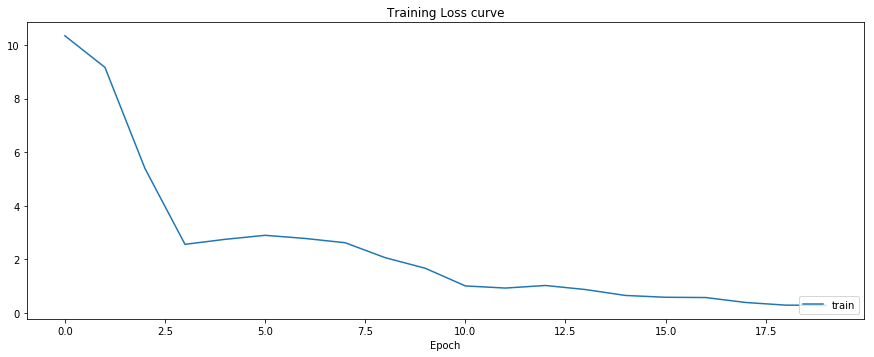

In [11]:
plt.subplot(2, 1, 1)
plt.title('Training Loss curve')
plt.plot(losses_train, '-',label='train')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

#### Developement of the BLEU4 score over the epochs for the training and validation set

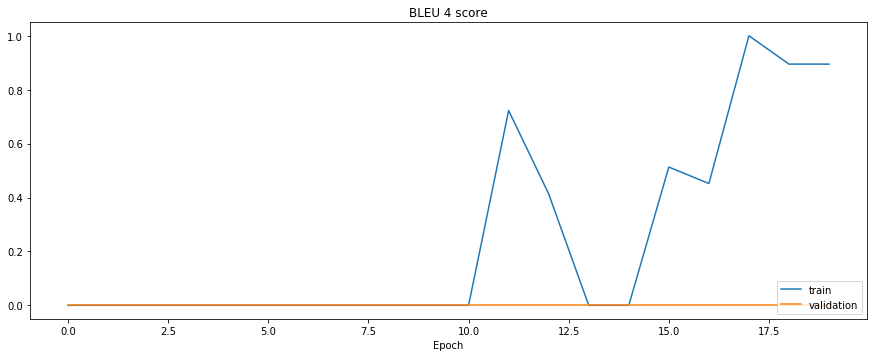

In [12]:
plt.subplot(2, 1, 1)
plt.title('BLEU 4 score')
plt.plot(bleus_4_train, '-',label='train')
plt.plot(bleus_4_val, '-',label='validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

#### Developement of the BLEU3 score over the epochs for the training and validation set

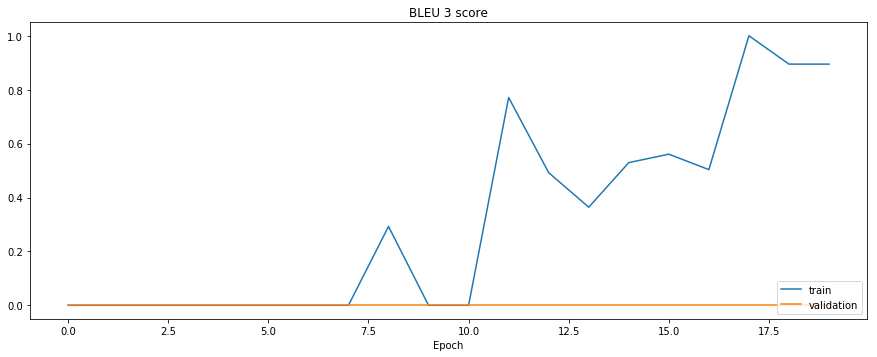

In [13]:
plt.subplot(2, 1, 1)
plt.title('BLEU 3 score')
plt.plot(bleus_3_train, '-',label='train')
plt.plot(bleus_3_val, '-',label='validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
#plt.savefig('../saved_models/7_3_splt_zeroshot/bleu3.png',transparent=True)
plt.show()

#### Developement of the BLEU2 score over the epochs for the training and validation set

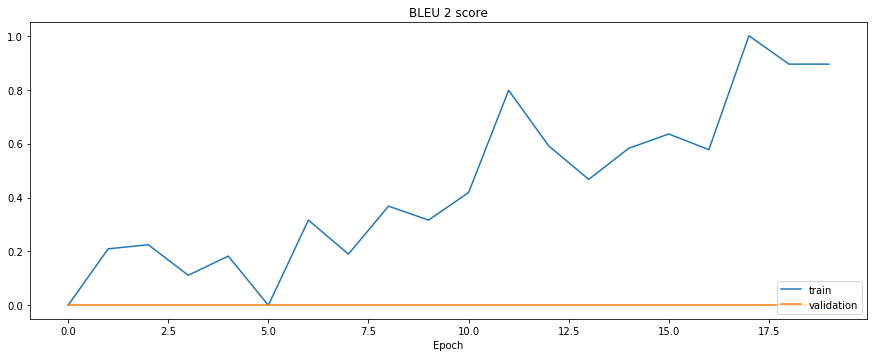

In [14]:
plt.subplot(2, 1, 1)
plt.title('BLEU 2 score')
plt.plot(bleus_2_train, '-',label='train')
plt.plot(bleus_2_val, '-',label='validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
#plt.savefig('../saved_models/7_3_splt_zeroshot/bleu2.png',transparent=True)
plt.show()

#### Developement of the BLEU1 score over the epochs for the training and validation set

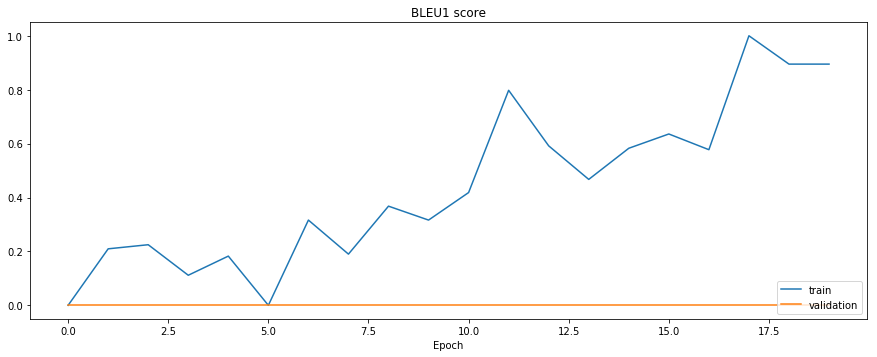

In [15]:
plt.subplot(2, 1, 1)
plt.title('BLEU1 score')
plt.plot(bleus_2_train, '-',label='train')
plt.plot(bleus_2_val, '-',label='validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

#### Developement of the METEOR score over the epochs for the training and validation set

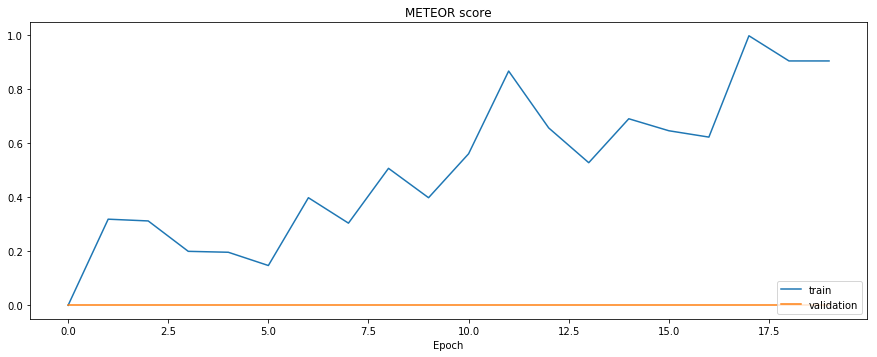

In [16]:
plt.subplot(2, 1, 1)
plt.title('METEOR score')
plt.plot(meteors_train, '-',label='train')
plt.plot(meteors_val, '-',label='validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()